<a href="https://colab.research.google.com/github/adrianrivadulla/FootNet_Development/blob/main/StepDetection_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CROSS-VALIDATION

5-fold cross validation is implemented to assess validation accuracy and stability of the proposed model architecture (HF: LSTMFootNetwork)and to select the best set of weights. 

The notebook requires DataFolds.npy to exist in StepDetectionStudy > Data directory. DataFolds.npy (and TestingSet.npy) was generated using the notebook called TrainTest_Split.npy.

DataFolds contains five folds of participants that are going to be used for 5-fold crossvalidation. This notebook iterates through each of those data folds saving the selected one for validation and concatenating the other four sets for training. When training converges, the performance of the model is assessed on the validation set, the model is saved alongside performance metrics. After all the data folds have been used for validation and five models are trained, this notebook looks at the validation accuracy of each model and selects the best one as the best candidate for the final test.



**Make sure you're running on GPU before starting the notebook**, otherwise it may not be able to finish before Google kicks you out in 12 hours.




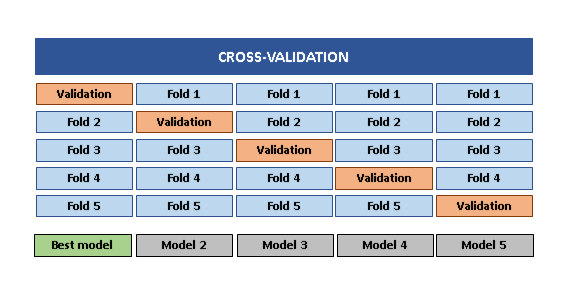

# Presettings

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Make imports

In [ ]:
import sys
import platform
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import pickle
import shutil
import os

## Directories

In [ ]:
crossvaldir = '/content/drive/My Drive/StepDetectionStudy/CrossValidation'
datadir = '/content/drive/My Drive/StepDetectionStudy/Data'
finaltestdir = '/content/drive/My Drive/StepDetectionStudy/FinalTest'

# Helper functions (HF)

## FlattenDataset

Flattens an structed list containing participants in the first sublevel (DatasetList[0]) and trials in the following sublevel (DatasetList[0][0])

In [ ]:
def FlattenDataset(DatasetList):
    FlatList = []
    for participant in DatasetList:
        for trial in participant:
                FlatList = FlatList + trial
                
    return FlatList

## StandardiseData

Transforms X_train and X_val to z-scores using the mean and standard deviation of each variable in the training set X_train.

In [ ]:
def StandardiseData(X_train, X_val):
    
    # calculate standardising factors
    zero_mean = np.mean(np.hstack(X_train), axis=(0,1)) # mean of each variable
    one_std = np.std(np.hstack(X_train), axis=(0,1)) # std of each variable

    # standardise data
    for i in range(len(X_train)):
        for idim in range(len(zero_mean)):
            X_train[i][:,:,idim] = (X_train[i][:,:,idim] - zero_mean[idim])/ one_std[idim]

    for i in range(len(X_val)):
        for idim in range(len(zero_mean)):
            X_val[i][:,:,idim] = (X_val[i][:,:,idim] - zero_mean[idim])/ one_std[idim]
        
    return X_train, X_val, zero_mean, one_std


## ListToPaddedArray

Zero-pads MatList to arrays of maxlen. The padding is added at the beginning.

In [ ]:
def ListToPaddedArray(MatList, maxlen):
    
    padded =np.empty((0,maxlen,MatList[0].shape[2]))
    
    for i in MatList:
        ipad = np.pad(i,((0,0),(maxlen-i.shape[1], 0),(0,0)),'constant')
        padded = np.vstack((padded, ipad))
            
    return padded


## LSTMNetwork

Model architecture. The iput shape, LSTM units and dense nodes in the dense layer have to be passed as input and it returns a model object.

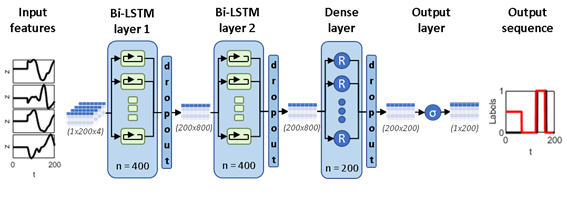

In [ ]:
def LSTMNetwork(InputShape, LSTMUnits, DenseNodes):
  
## MODEL ARCHITECTURE

  # Input layer
  inputs = keras.Input(shape=InputShape, dtype="float")
  
  # Masking layer for padding
  x = layers.Masking(mask_value=0)(inputs)
  
  # Layer 1. Bi-LSTM layer 1
  x = layers.Bidirectional(layers.LSTM(LSTMUnits,
                                       input_shape = InputShape,
                                       return_sequences=True))(x)
  # Dropout layer 1
  x = layers.Dropout(0.5)(x)
  
  # Layer 2. Bi-LSTM layer 2
  x = layers.Bidirectional(layers.LSTM(LSTMUnits,
                                       input_shape = InputShape,
                                       return_sequences=True))(x)
  # Dropout layer 2
  x = layers.Dropout(0.5)(x)
  
  # Layer 3. Fully-connected layer
  x = layers.Dense(DenseNodes, activation = "relu")(x)
  
  #Dropout layer 3
  x = layers.Dropout(0.5)(x)
  
  #Output layer
  outputs = layers.Dense(1,input_shape=(DenseNodes,1), activation="sigmoid")(x)

## CREATE MODEL

  model = keras.Model(inputs, outputs)
  model.summary() # print out model architecture

## COMPILE MODEL WITH OPTIMISER, LOSS FUNCTION AND PERFORMANCE METRICS

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

  return model

## GetStepEvents

Finds the first (foot-strike, fs) and last (toe-off, to) value in Labels that are > 0.51 i.e. contact. Labels is a list containing n strides.

In [ ]:
def GetStepEvents(Labels):
    
    fs = []
    to = []    
    
    for stride in Labels:
      if len(stride.shape) == 2:

        fs.append(np.where(stride[:,0] > 0.51)[0][0])
        to.append(np.where(stride[:,0] > 0.51)[-1][-1]+1)
        
      elif len(stride.shape) == 3:

        fs.append(np.where(stride[0,:,1] > 0.51)[0][0])
        to.append(np.where(stride[0,:,1] > 0.51)[-1][-1]+1)
      
    return fs, to


## PerformanceAssessment

Compares the original labels (Y_labels) against the predicted ones (Y_hat). Foot-strike and toe-off are detected in both real and predicted labels using the GetStepEvents funciton and then the difference (in ms) is calculated. Error metrics including precision, RMSE, parametric Bland-Altman 95% limits of agreement, 99 percentile and max error are calculated. Bland-Altman plots are saved to savingdir including the fold code valfold in the name so they can be identified.

In [ ]:
def PerformanceAssessment(Y_labels, Y_hat, metadata, savingdir, valfold):

  # get gold standard contact events
  fs, to = GetStepEvents(Y_labels)    

  # get predicted contact events
  fs_hat,to_hat = GetStepEvents(Y_hat)

  # everything to milliseconds
  lastBra = [i for i, trialname in enumerate(metadata) if 'RBDS' in trialname][-1]

  fs_ms = np.zeros_like(fs, dtype=float)
  to_ms = np.zeros_like(to, dtype=float)

  fs_hat_ms = np.zeros_like(fs_hat, dtype=float)
  to_hat_ms = np.zeros_like(to_hat, dtype=float)

  for i in range(len(fs)):
    if i <= lastBra:
      fs_ms[i] = fs[i]*1/150
      to_ms[i] = to[i]*1/150
      fs_hat_ms[i] = fs_hat[i]*1/150
      to_hat_ms[i] = to_hat[i]*1/150

    else:
      fs_ms[i] = fs[i]*1/200
      to_ms[i] = to[i]*1/200
      fs_hat_ms[i] = fs_hat[i]*1/200
      to_hat_ms[i] = to_hat[i]*1/200

  # calculate errors
  ct_ms = to_ms - fs_ms
  ct_hat_ms = to_hat_ms - fs_hat_ms

  FSError = fs_ms - fs_hat_ms
  TOError = to_ms - to_hat_ms
  CTError = ct_ms - ct_hat_ms

  ## Error metrics

  # Precision
  fs_prec = np.count_nonzero(FSError == 0)/len(FSError)*100
  to_prec = np.count_nonzero(TOError == 0)/len(TOError)*100
  ct_prec = np.count_nonzero(CTError == 0)/len(CTError)*100

  # RMSE
  rmse_fs = np.sqrt(np.mean(FSError**2))
  rmse_to = np.sqrt(np.mean(TOError**2))
  rmse_ct = np.sqrt(np.mean(CTError**2))

  # Bland-Altman plots
  plt.figure()
  fs95top, fs95bottom = BlandAltmanPlot(fs_ms, fs_hat_ms, to_ms - fs_ms, valfold,'Contact_time (ms)','Error (ms)')
  plt.savefig(savingdir + '/FSBAplot_' + valfold + '.jpg')

  plt.figure()
  to95top, to95bottom = BlandAltmanPlot(to_ms, to_hat_ms, to_ms - fs_ms, valfold,'Contact_time (ms)','Error (ms)')
  plt.savefig(savingdir + '/TOBAplot_' + valfold + '.jpg')

  plt.figure()
  ct95top, ct95bottom = BlandAltmanPlot(ct_ms, ct_hat_ms, to_ms - fs_ms, valfold,'Contact_time (ms)','Error (ms)')
  plt.savefig(savingdir + '/CTBAplot_' + valfold + '.jpg')

  # 99 pctile
  fs_99 = np.percentile(np.abs(FSError),99)
  to_99 = np.percentile(np.abs(TOError),99)
  ct_99 = np.percentile(np.abs(CTError),99)

  # max error
  max_fs_error = max(np.abs(FSError))
  max_to_error = max(np.abs(TOError))
  max_ct_error = max(np.abs(CTError))

  # write it all out as a dictionary
  summary = {"precision" : [fs_prec, to_prec, ct_prec],
             "rmse" : [rmse_fs, rmse_to, rmse_ct],
             "95la" : [[fs95top, fs95bottom], [to95top, to95bottom], [ct95top, ct95bottom]],
             "pctile_99" : [fs_99, to_99, ct_99],
             "max_error" : [max_fs_error, max_to_error, max_ct_error]}

  return summary, fs_ms, fs_hat_ms, to_ms, to_hat_ms

## BlandAltmanPlot

Displays a Bland-Altman plot where the disagreement between two instruments (y-axis) is plotted against a variable t (time in this case for visualisation purposes, x-axis). The 95% limits of agreeement are calculated parametrically i.e. mean disagreement +- 1.96*sd disagreement) and returned as input. The figure includes the 0 line disagreement line, mean disasgreement line, upper and lower 95% limits of agreement and regression line between disagreement and variable t.

In [ ]:
def BlandAltmanPlot(data1, data2, t, PlotTitle, XLabel, YLabel, *args, **kwargs):

    data1     = np.asarray(data1)               # instrument 1
    data2     = np.asarray(data2)               # instrument 2
    mean      = np.mean([data1, data2], axis=0) # mean of instrument 1 and 2
    diff      = data1 - data2                   # Difference between data1 and data2
    bias      = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    toplim    = bias + 1.96*sd
    bottomlim = bias - 1.96*sd
    line      = np.polyfit(t, diff, 1)

    plt.scatter(t, diff, *args, **kwargs)
    plt.axhline(bias, color='red', linestyle='-')
    plt.axhline(0, color='black', linestyle='-')
    plt.axhline(toplim, color='black', linestyle='-')
    plt.axhline(bottomlim, color='black', linestyle='-')

    axes = plt.gca()
    x = np.array(axes.get_xlim())
    y = line[0] * x + line[1]
    plt.plot(x, y, '--')
    plt.axhspan(bias - 1.96*sd, bias + 1.96*sd , alpha=0.5, color='grey')

    plt.title(PlotTitle)
    plt.xlabel(XLabel)
    plt.ylabel(YLabel)
 
    return toplim, bottomlim

# What am I running on?

Machine specs

PC

In [ ]:
!lscpu

GPU

In [ ]:
!nvidia-smi -L

Software

In [ ]:
# OS
print('OS:')
print(platform.system())
print(platform.release())
print(platform.linux_distribution())
print(' ')

# Python
print('Python version:')
print(sys.version)
print(' ')

# Tensorflow
print('Tensorflow version:')
print(tensorflow.__version__)

# Main 

## Load data

In [ ]:
data = np.load(datadir + '/DataFolds.npy', allow_pickle=True)
data = data.item()

## 5-fold crossvalidation

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 4)]          0         
_________________________________________________________________
masking (Masking)            (None, 200, 4)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 800)          1296000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 800)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 800)          3843200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 800)          0         
_________________________________________________________________
dense (Dense)                (None, 200, 200)         

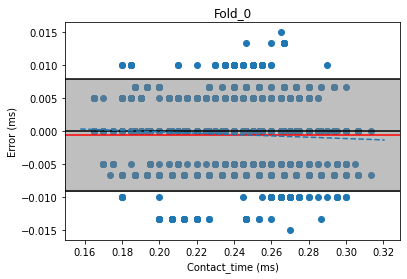

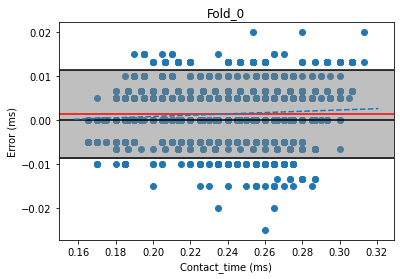

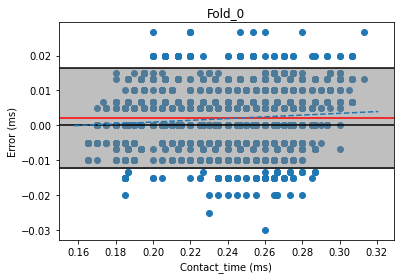

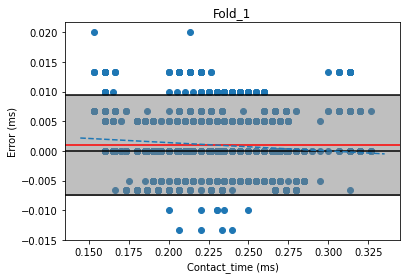

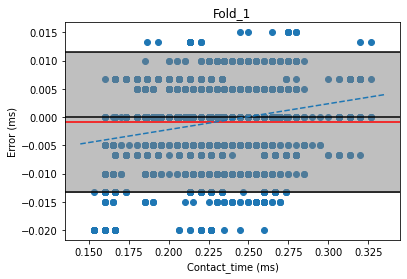

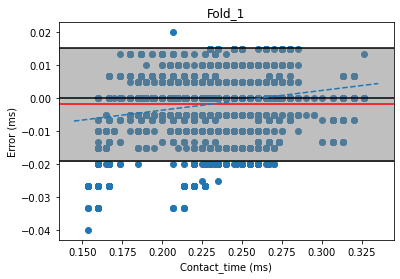

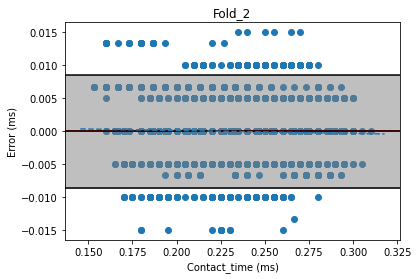

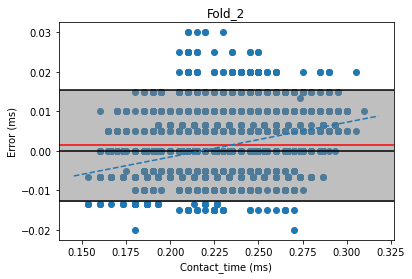

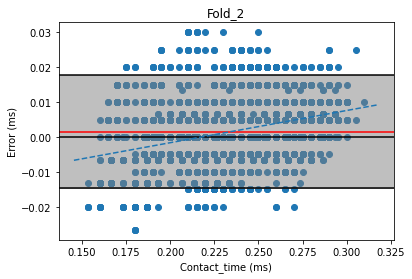

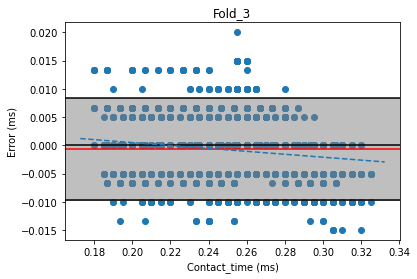

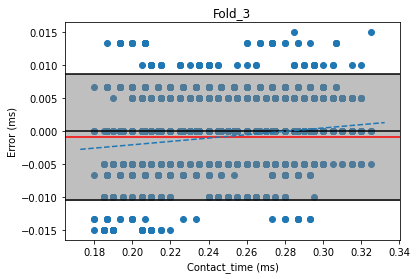

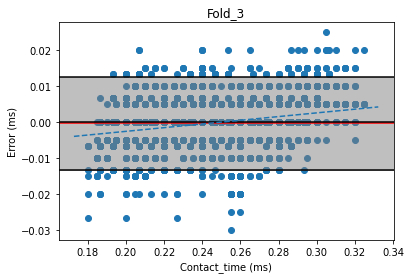

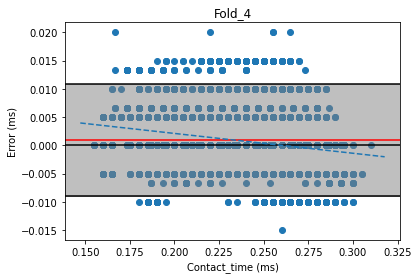

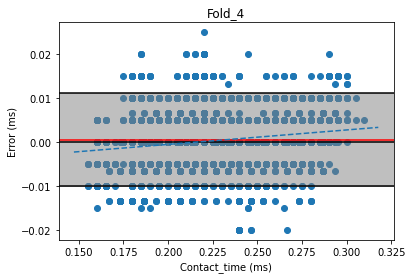

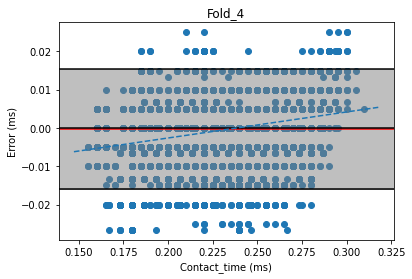

In [ ]:
for valfold in list(data.keys()): # using one fold as validation set each time
  
## VALIDATION SET
  valset = {}
  valset = data[valfold].copy() # assign validation set

## TRAINING SET

  trainset = {}
  
  # concatenate the other folds
  for key in list(valset.keys()):
    trainset[key] = []  
    for trainfold in [fold for fold in list(data.keys()) if fold != valfold]:
      trainset[key] = trainset[key] + data[trainfold][key]

## CREATE X, Y, META AND GRFv SETS AS LISTS OF STRIDES

  for key in list(valset.keys()):
    valset[key] = FlattenDataset(valset[key])
    trainset[key] = FlattenDataset(trainset[key])

## STANDARDISE DATA

  trainset['X'], valset['X'], zero_mean, one_std = StandardiseData(trainset['X'], valset['X'])

## PADD DATA

  X_train = ListToPaddedArray(trainset['X'], 200)
  Y_train = ListToPaddedArray(trainset['Y'], 200)
  X_val = ListToPaddedArray(valset['X'], 200)
  Y_val = ListToPaddedArray(valset['Y'], 200)
  
## MODEL TRAINING

  # Create model
  FootNet = LSTMNetwork((200, 4), 400, 200)

  # Create callback function for early stopping
  es = EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=10,
                     verbose=1, restore_best_weights=True)
  # Train the model
  history = FootNet.fit(X_train, Y_train, batch_size=200, epochs=100,
                        validation_data=(X_val,Y_val), callbacks=[es])

## MODEL ASSESSMENT

  y_hat = FootNet.predict(X_val)
    
  # get rid of noise in predictions due to padding
  for i, labelvector in enumerate(y_hat):
    padend = np.where(labelvector[:,0] < 0.1)[0][0]
    labelvector[:padend,0] = 0
    y_hat[i] = labelvector
      
  summary = PerformanceAssessment(Y_val, y_hat, valset['meta'], crossvaldir + '/Results', valfold) 

## SAVE STUFF

  # save model
  FootNet.save(crossvaldir +'/Models/FootNet' + valfold)

  # save history and performance summary in results dic
  results = {}
  results['summary'] = summary
  results['history'] = history.history
  with open(crossvaldir + '/Results/summary_'+ valfold, 'wb') as f:
   pickle.dump(results, f)


# Select best model

Model 0
Max validation accuracy
0.9908356070518494
Achieved in 8 epochs
Model 1
Max validation accuracy
0.9896854758262634
Achieved in 16 epochs
Model 2
Max validation accuracy
0.9877707958221436
Achieved in 24 epochs
Model 3
Max validation accuracy
0.9907999634742737
Achieved in 10 epochs
Model 4
Max validation accuracy
0.9891143441200256
Achieved in 17 epochs
 
 
Best model
FootNetFold_0
 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

'/content/drive/My Drive/StepDetectionStudy/FinalTest/FootNet_best_candidate'

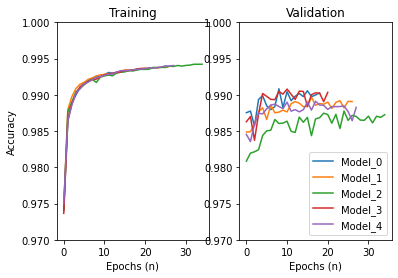

In [ ]:
# load summary of results of each model

models = {}
models['0'] = np.load(crossvaldir + '/Results/summary_Fold_0', allow_pickle=True)
models['1'] = np.load(crossvaldir + '/Results/summary_Fold_1', allow_pickle=True)
models['2'] = np.load(crossvaldir + '/Results/summary_Fold_2', allow_pickle=True)
models['3'] = np.load(crossvaldir + '/Results/summary_Fold_3', allow_pickle=True)
models['4'] = np.load(crossvaldir + '/Results/summary_Fold_4', allow_pickle=True)

# print out accuracy x epoch plots and select model with highest accuracy

modelnames = list(models.keys())

val_acc = []
max_epoch = []

plt.figure()
maxacc = []
for modelname in modelnames:

  plt.subplot(1,2,1)
  plt.plot(models[modelname]['history']['binary_accuracy'])
  plt.subplot(1,2,2)
  plt.plot(models[modelname]['history']['val_binary_accuracy'])
  
  print('Model ' + modelname)
  maxacc = np.max(models[modelname]['history']['val_binary_accuracy'])
  maxepoch = models[modelname]['history']['val_binary_accuracy'].index(max(models[modelname]['history']['val_binary_accuracy']))
  print('Max validation accuracy')
  print(maxacc)
  print('Achieved in ' + str(maxepoch) + ' epochs')
  val_acc.append(maxacc)
  max_epoch.append(maxepoch)

bestmodelidx = val_acc.index(max(val_acc))
print(' ')
print('======================')
print(' ')
print('Best model')
print('FootNetFold_' + str(bestmodelidx))
print(' ')
print('======================')


plt.subplot(1,2,1)
plt.ylim([0.97, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.title('Training')
plt.subplot(1,2,2)
plt.ylim([0.97, 1])
plt.xlabel('Epochs (n)')
plt.title('Validation')
legend = ['Model_' + modelname for modelname in modelnames]
plt.legend(legend)

# copy best model in FinalTest dir
if os.path.exists(finaltestdir + '/FootNet_best_candidate'): # delete if model already exists
  shutil.rmtree(finaltestdir + '/FootNet_best_candidate')
shutil.copytree(crossvaldir+ '/Models/FootNetFold_' + str(bestmodelidx), finaltestdir + '/FootNet_best_candidate')


In [ ]:
a = str(np.where(max(val_acc)))

In [ ]:
max_idx = val_acc.index(max(val_acc))
max_idx

0

[0.9875338077545166, 0.9877589344978333, 0.9857124090194702, 0.9893673658370972, 0.9898799061775208, 0.98848956823349, 0.9879562854766846, 0.9883787631988525, 0.9908356070518494, 0.9882436990737915, 0.9904443621635437, 0.989192545413971, 0.9898037314414978, 0.9901950359344482, 0.9897569417953491, 0.9905620813369751, 0.9897448420524597, 0.9899768233299255, 0.9902660250663757]
[0.9740235209465027, 0.9863322377204895, 0.9888656139373779, 0.9899827837944031, 0.9910057783126831, 0.9916766881942749, 0.9919742345809937, 0.9922224879264832, 0.9925761222839355, 0.9925081729888916, 0.9927762746810913, 0.9930838346481323, 0.9929817914962769, 0.9931003451347351, 0.9931280612945557, 0.9933310747146606, 0.9933339357376099, 0.9934561252593994, 0.9934485554695129]


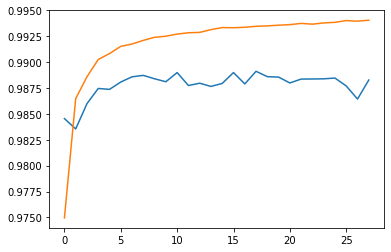

In [ ]:
print(models['0']['history']['val_binary_accuracy'])
print(models['0']['history']['binary_accuracy'])
plt.figure()
plt.plot(models['4']['history']['val_binary_accuracy'])
plt.plot(models['4']['history']['binary_accuracy'])
